# What drives the price of a car?

![](images/kurt.jpeg)

### Business Understanding


The client, a used car dealership, seeks recommendations on what consumers value in pre-owned cars. In order to determine the attributes affecting a used car's value, we will regularize and train a regression model using a dataset containing information on 426 thousand used cars. The accuracy of the predictions willl be ensured through various cross validation techniques evaluating the mean squared error (MSE), and the resulting regression coefficients from the model will provide valueable insights on the impact of different attributes on a car's value. In addition, we will use permutation importance to interpret the findings and better understand what drives pre-owned car prices.

### Data Understanding
First we will import the dataset and get information on the columns, such as column names, number of non-null values etc. From this info, we can check for missing values and consider if it should be replaced/deleted. Additionally, not all information contained in the dataset will provide value to our model and some columns can also be deleted. For non-numeric data, it will be useful to make a list of unique values and counts for each column, which will help with deciding which transformer to use later on.  Lastly, we'll make initial predictions for how important a feature is and drop rows/columns based on this prediction during cleaning. The target variable in this case is 'price', which we will seperate from our predictor variable.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Import data
df = pd.read_csv('data/vehicles.csv')

In [3]:
# Overview of data
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [4]:
# Get info on dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [5]:
# Print the value counts of each object type columns
for col in df.select_dtypes(exclude='number').columns:
    val_list = df[col].value_counts()
    print(val_list, "\n")

region
columbus                   3608
jacksonville               3562
spokane / coeur d'alene    2988
eugene                     2985
fresno / madera            2983
                           ... 
meridian                     28
southwest MS                 14
kansas city                  11
fort smith, AR                9
west virginia (old)           8
Name: count, Length: 404, dtype: int64 

manufacturer
ford               70985
chevrolet          55064
toyota             34202
honda              21269
nissan             19067
jeep               19014
ram                18342
gmc                16785
bmw                14699
dodge              13707
mercedes-benz      11817
hyundai            10338
subaru              9495
volkswagen          9345
kia                 8457
lexus               8200
audi                7573
cadillac            6953
chrysler            6031
acura               5978
buick               5501
mazda               5427
infiniti            4802
lincoln     

From the data above, we see that the columns 'region' and 'model' have many unique values, some with very few counts. The columns provide additional specificity to the columns 'state' and 'manufacturer', respectively. This level of details will likely not add value to our model and complicate cross validation.

In [6]:
# Check variations in 'size' for each 'type' to check for redundancy
df.dropna(subset=['size'])[['size','type']].groupby('type').value_counts()

type         size       
SUV          full-size      14738
             mid-size       11727
             compact         2289
             sub-compact      225
bus          full-size        211
             compact           33
             mid-size          27
             sub-compact        1
convertible  compact         1125
             mid-size        1087
             full-size        574
             sub-compact      493
coupe        mid-size        2260
             compact         2235
             full-size       1523
             sub-compact      911
hatchback    compact         2602
             mid-size        1251
             full-size        571
             sub-compact      540
mini-van     full-size       1450
             mid-size         701
             compact           66
             sub-compact       26
offroad      full-size        232
             mid-size         126
             compact           44
             sub-compact        7
other        compact   

We can see that all listed types of car can be categorized by size and there's no redundancy of information between these two columns.

After getting to know the data, the initial predictions for feature importance are as follows:

 **High Importance**
 
 - Year
 - Manufacturer
 - Odometer
 
 **Medium Importance**
 - Condition
 - Title status
 - Cylinders
 - Fuel
 - Transmission
 - Drive
 - Size
 - Type
 
 **Low Importance**
 - Color
 - State
 
 **No Importance**
 - ID
 - VIN
 
 **Too Specific**
 - Region
 - Model
 
 **Target Variable**
 - Price

### Data Preparation 

#### Data Cleaning
The plan is to first, drop columns that have no importance. Then, drop rows missing data from the "High Importance" columns since those data points would not be very useful without important features. Next we will drop missing data from the "Medium Importance" columns. To keep computational time reasonable but still have enough data to make accurate predictions we will aim for between 10-100K data points. If we have less than 10K data points after this step we can add some rows back in and fill missing values with 'unknown'. Otherwise, we will proceed with checking "Low Importance" columns for missing data and also fill in missing values with 'unknown'.

In [7]:
# Drop "No Importance" columns
df = df.drop(['id', 'VIN'], axis = 1)

In [8]:
# Drop "Too Specific" columns
df = df.drop(['region', 'model'], axis = 1)

In [9]:
# Drop missing rows from "High Importance" columns
df = df.dropna(subset=['year', 'manufacturer', 'odometer'])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 405077 entries, 27 to 426879
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         405077 non-null  int64  
 1   year          405077 non-null  float64
 2   manufacturer  405077 non-null  object 
 3   condition     240069 non-null  object 
 4   cylinders     238187 non-null  object 
 5   fuel          403068 non-null  object 
 6   odometer      405077 non-null  float64
 7   title_status  397873 non-null  object 
 8   transmission  403453 non-null  object 
 9   drive         283273 non-null  object 
 10  size          114520 non-null  object 
 11  type          319544 non-null  object 
 12  paint_color   282835 non-null  object 
 13  state         405077 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 46.4+ MB


In [11]:
# Drop missing values in 'Medium Importance' column
df = df.dropna(subset=['size', 'type', 'condition', 'drive', 'cylinders', 'transmission', 'fuel', 'title_status'])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83047 entries, 31 to 426836
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         83047 non-null  int64  
 1   year          83047 non-null  float64
 2   manufacturer  83047 non-null  object 
 3   condition     83047 non-null  object 
 4   cylinders     83047 non-null  object 
 5   fuel          83047 non-null  object 
 6   odometer      83047 non-null  float64
 7   title_status  83047 non-null  object 
 8   transmission  83047 non-null  object 
 9   drive         83047 non-null  object 
 10  size          83047 non-null  object 
 11  type          83047 non-null  object 
 12  paint_color   80170 non-null  object 
 13  state         83047 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 9.5+ MB


Note that we have more than 10K data points still. So we move on with "Low Importance" columns

In [13]:
# Replace missing values with 'unknown'
df = df.replace(np.nan, 'unknown')

#### Separate Predictive and Target Variables

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
# Designate 'price' as y and all other features as X
X = df.drop('price', axis = 1)
y = df['price']

# Reset index starting from 0
X = X.reset_index(drop=True)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

#### Features Engineering
We can build a preliminary column transformer with PolynomialFeaures for the numeric columns, OrdinalEncoder for the column 'condition', and OneHotEncoder for all other non-numeric columns. Note that we do not yet know what degree polynomial will be best for the various models we will build. 

In [16]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector

In [17]:
# Make transformer
tf = make_column_transformer((PolynomialFeatures(), make_column_selector(dtype_include=np.number)),
                             (OrdinalEncoder(categories = [['salvage', 'fair', 'good', 'excellent', 'like new', 'new']]), ['condition']),
                             (OneHotEncoder(drop = 'if_binary'), ['manufacturer', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state']))

### Modeling

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector, RFE
import seaborn as sns

#### Testing for best polynomial degree

The best degree polynomial model for linear regression is:  1
The test MSE from this model is: 1031509561750.4729


[Text(0.5, 0, 'Polynomial Degree'),
 Text(0, 0.5, 'Mean Squared Error'),
 Text(0.5, 1.0, 'Test MSE vs Polynomial Degree')]

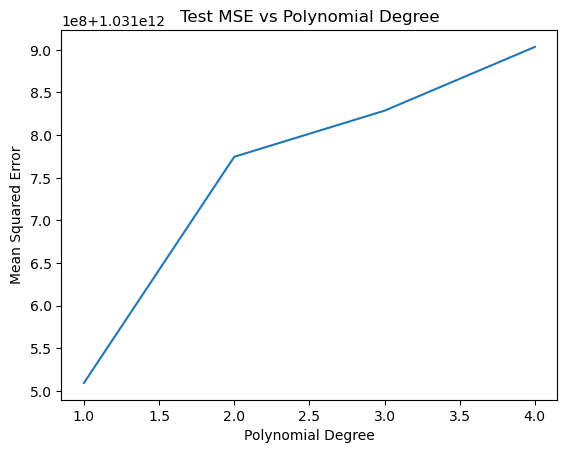

In [19]:
# Find best MSE for polynomial degree 1-4 using linear regression
linear_test_mses = []
for i in range(1, 5):
    tf = make_column_transformer((PolynomialFeatures(degree = i, include_bias = False), make_column_selector(dtype_include=np.number)),
                                 (OrdinalEncoder(categories = [['salvage', 'fair', 'good', 'excellent', 'like new', 'new']]), ['condition']),
                                 (OneHotEncoder(drop = 'if_binary'), ['manufacturer', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state']))
    lin_pipe = Pipeline([('transformer', tf),
                         ('scaler', StandardScaler(with_mean=False)),
                         ('linreg', LinearRegression())])
    lin_pipe.fit(X_train, y_train)
    lin_pred_test = lin_pipe.predict(X_test)
    lin_mse_test = mean_squared_error(lin_pred_test, y_test)
    linear_test_mses.append(lin_mse_test)
print(f'The best degree polynomial model for linear regression is:  {linear_test_mses.index(min(linear_test_mses)) + 1}')
print(f'The test MSE from this model is: {min(linear_test_mses)}')

# Plot MSE vs Polynomial Degree
sns.lineplot(x = list(range(1,5)), y =  linear_test_mses).set(xlabel='Polynomial Degree', ylabel='Mean Squared Error', title = 'Test MSE vs Polynomial Degree')

We can see from the above graph that a model of degree 1 yields the lowerest mean squared error, and we see that there's an increase in error from 1 to 2. To make computation more efficient we will proceed with using degree one for the rest of our models.

#### Ridge Regression- Finding best alpha

The best alpha value for ridge regression is:  722080.9018385457
The K-fold cross-validation test MSE from this model is: 740753114134.7269


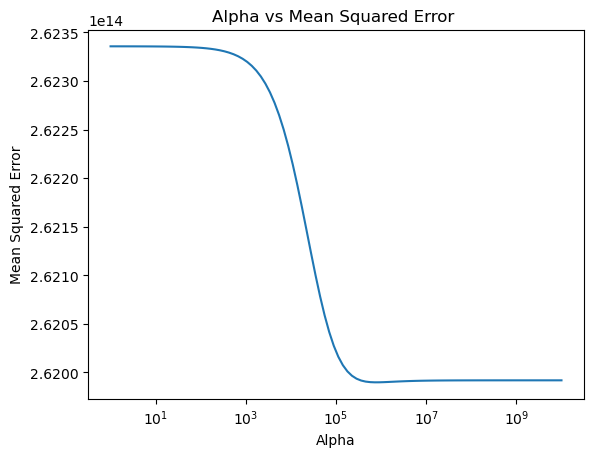

In [20]:
# Make new transformer without Polynomial Features
tf = make_column_transformer((OrdinalEncoder(categories = [['salvage', 'fair', 'good', 'excellent', 'like new', 'new']]), ['condition']),
                             (OneHotEncoder(drop = 'if_binary'), ['manufacturer', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state']))

# Define list of alpha values to test for
ridge_param_dict = {'ridge__alpha': np.logspace(0, 10, 100)}

# Create Pipeline
ridge_pipe = Pipeline([('transformer', tf),
                       ('scaler', StandardScaler(with_mean=False)),
                       ('ridge', Ridge())])

# Use K-fold validation (default 5 folds) to find best alpha
ridge_grid = GridSearchCV(ridge_pipe, ridge_param_dict, scoring = 'neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)
ridge_pred_test = ridge_grid.best_estimator_.predict(X_test)
ridge_mse_test = mean_squared_error(ridge_pred_test, y_test)
best_alpha_ridge = ridge_grid.best_estimator_.named_steps['ridge'].alpha

# Plot alpha vs error
print(f'The best alpha value for ridge regression is:  {best_alpha_ridge}')
print(f'The K-fold cross-validation test MSE from this model is: {ridge_mse_test}')
plt.plot(np.logspace(0, 10, 100),[-x for x in ridge_grid.cv_results_['mean_test_score']])
plt.title('Alpha vs Mean Squared Error ')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.xscale('log')

The best alpha value for ridge regression is:  9326033.468832199
The holdout validation test MSE from this model is: 734980937282.9451


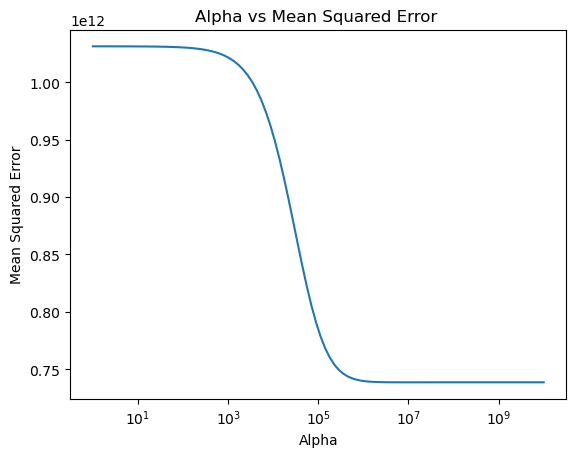

In [21]:
# Get train and test indices
X_train_idx = list(X_train.index)
X_test_idx = list(X_test.index)

# Use hold-out cross validation to find optimal alpha
ridge_grid_holdout = GridSearchCV(ridge_pipe, ridge_param_dict, scoring = 'neg_mean_squared_error', cv = [[X_train_idx, X_test_idx]])
ridge_grid_holdout.fit(X, y)
ridge_pred_test_holdout = ridge_grid_holdout.best_estimator_.predict(X_test)
ridge_mse_test_holdout = mean_squared_error(ridge_pred_test_holdout, y_test)
best_alpha_ridge_holdout = ridge_grid_holdout.best_estimator_.named_steps['ridge'].alpha

#Plot alpha vs error
print(f'The best alpha value for ridge regression is:  {best_alpha_ridge_holdout}')
print(f'The holdout validation test MSE from this model is: {ridge_mse_test_holdout}')
plt.plot(np.logspace(0, 10, 100),[-x for x in ridge_grid_holdout.cv_results_['mean_test_score']])
plt.title('Alpha vs Mean Squared Error ')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.xscale('log')

#### Sequential Feature Selection and Recursive Feature Elimination + LASSO

LASSO regression is another method we can try, although the full dataframe is a bit too computationally intensive for LASSO regression. A workaround would be to use sequential feature selection and recursive feature elimination to limit the number of features we have to work with, then apply LASSO regression.

In [22]:
# Add column titles to transformed dataframe
transformed_df = pd.DataFrame.sparse.from_spmatrix(tf.fit_transform(X_train))
transformed_df = transformed_df.set_axis(tf.get_feature_names_out(), axis=1)

In [32]:
# Select top 5 features using SFS
SFS_selector_linear = SequentialFeatureSelector(LinearRegression(), n_features_to_select= 5)
SFS_selector_linear.fit_transform(transformed_df, y_train)
print(SFS_selector_linear.get_feature_names_out())

['onehotencoder__manufacturer_aston-martin'
 'onehotencoder__manufacturer_ferrari'
 'onehotencoder__manufacturer_land rover'
 'onehotencoder__title_status_parts only'
 'onehotencoder__paint_color_white']


In [33]:
# Select top 5 features using RFE
RFE_selector_linear = SequentialFeatureSelector(LinearRegression(), n_features_to_select= 5)
RFE_selector_linear.fit_transform(transformed_df, y_train)
print(RFE_selector_linear.get_feature_names_out())

['onehotencoder__manufacturer_aston-martin'
 'onehotencoder__manufacturer_ferrari'
 'onehotencoder__manufacturer_land rover'
 'onehotencoder__title_status_parts only'
 'onehotencoder__paint_color_white']


SFS and RFE both selected the same top 5 features, which we will use in Lasso regression below. We'll be using the default alpha value of 1.

In [25]:
# Define and fit selector
selector_pipe = Pipeline([('transformer', tf),
                           ('selector', SequentialFeatureSelector(LinearRegression(), 
                                                                  n_features_to_select=5)),
                           ('lasso', Lasso())])
selector_pipe.fit(X_train, y_train)
selector_test_mse = mean_squared_error(y_test, selector_pipe.predict(X_test))
print(f'The test MSE from lasso regression model is: {selector_test_mse}')

The test MSE from lasso regression model is: 738614344779.7971


### Evaluation

In [26]:
from sklearn.inspection import permutation_importance

Since ridge regression coefficients are assigned based on the predictive impact of each feature to minimize MSE, we can use this to evaluate what worked and what didn't.

In [27]:
# Get 5 most positive and negative ridge coefficients
coef_list = ridge_grid.best_estimator_.named_steps['ridge'].coef_
coef_dict = dict(zip(ridge_grid.best_estimator_[:-1].get_feature_names_out(), coef_list))
coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1], reverse = True)}
top_5 = {k: coef_dict[k] for k in list(coef_dict)[:5]}
bottom_5 = {k: coef_dict[k] for k in list(coef_dict)[-5:]}

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'onehotencoder__state_or'),
  Text(1, 0, 'onehotencoder__type_pickup'),
  Text(2, 0, 'onehotencoder__manufacturer_toyota'),
  Text(3, 0, 'onehotencoder__paint_color_silver'),
  Text(4, 0, 'onehotencoder__cylinders_8 cylinders'),
  Text(5, 0, 'onehotencoder__size_mid-size'),
  Text(6, 0, 'onehotencoder__type_SUV'),
  Text(7, 0, 'onehotencoder__drive_fwd'),
  Text(8, 0, 'onehotencoder__cylinders_4 cylinders'),
  Text(9, 0, 'onehotencoder__cylinders_6 cylinders')])

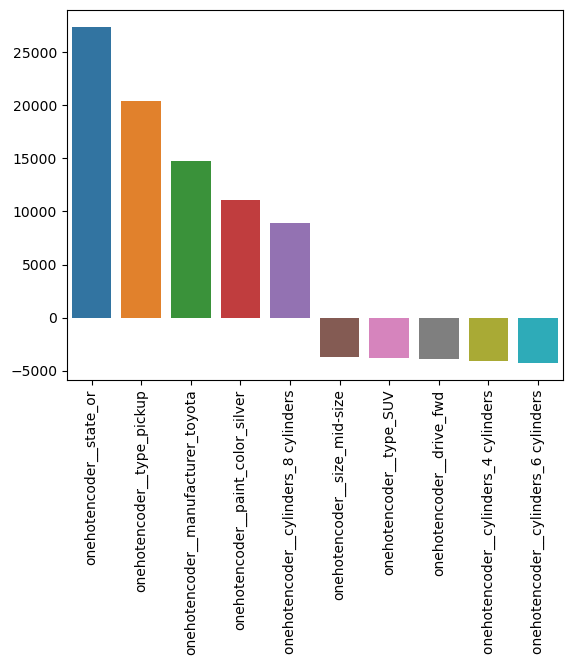

In [ ]:
# Plot coefficients
sns.barplot(x = list((top_5 | bottom_5).keys()), y = list((top_5 | bottom_5).values()))
plt.xticks(rotation=90)

The ridge regression coefficients indicate that the best performing features for predicting prices were:
- State = Or
- Type = pickup
- Manufacturer = Toyota
- Paint color = silver
- Cylinders = 8 cylinders
The worst performing features were:
- Cylinders = 6 cylinders
- Cylinders = 4 cylinders
- Drive = fwd
- Type = SUV
- Size = mid size

Permutation importance provides insight on which columns affected price the most in our data set.

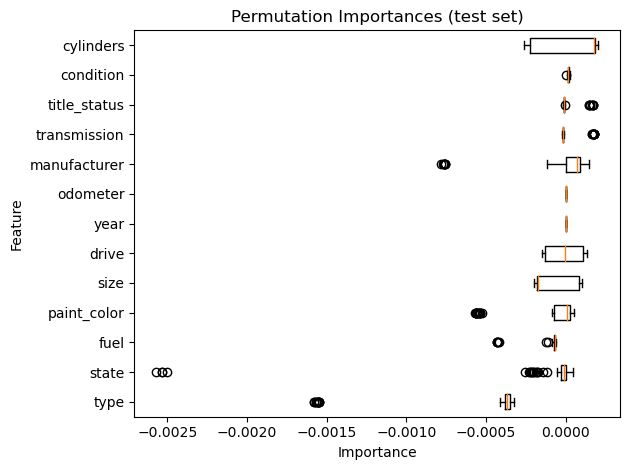

In [29]:
# Permutation Importance using ridge regression model
ridge_imp = permutation_importance(ridge_grid.best_estimator_, X_test, y_test, n_repeats = 100)
ridge_sorted_idx = ridge_imp.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(ridge_imp.importances[ridge_sorted_idx].T,
           vert=False, labels=X_train.columns[ridge_sorted_idx])
ax.set_title("Permutation Importances (test set)")
ax.set_ylabel('Feature')
ax.set_xlabel('Importance')
fig.tight_layout()
plt.show()

The results from permutation importance using ridge regression indicates that the best predictor for price is the number of cylinders. Although it also seems to suggest that none of the features were especially key for prediction. However we do see some outiers indicating that some states data performs very poorly, while some data on transmission performs best.

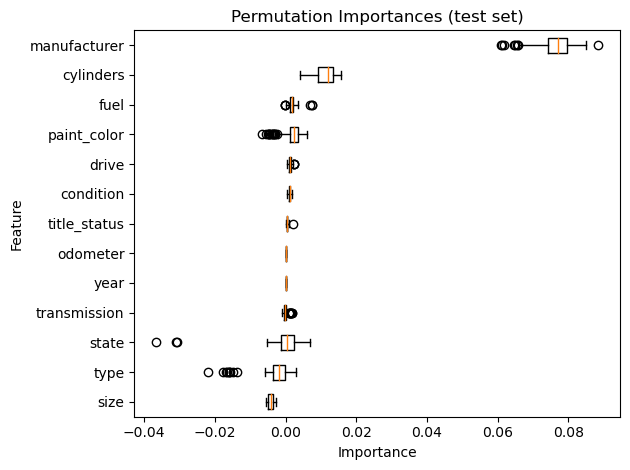

In [30]:
# Permutation importance using linear regression model
lin_pipe = Pipeline([('transformer', tf),
                     ('scaler', StandardScaler(with_mean=False)),
                     ('linreg', LinearRegression())])
lin_pipe.fit(X_train, y_train)
linear_imp = permutation_importance(lin_pipe, X_test, y_test, n_repeats = 100)
linear_sorted_idx = linear_imp.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(linear_imp.importances[linear_sorted_idx].T,
           vert=False, labels=X_train.columns[linear_sorted_idx])
ax.set_title("Permutation Importances (test set)")
ax.set_ylabel('Feature')
ax.set_xlabel('Importance')
fig.tight_layout()
plt.show()

Permutation importance using the linear model shows that manufacturer is by far the best indicator for price. Number of cylinders also contributes to price prediction. This seems to agree with the results we previously saw with feature selection when we were building our model. To recap, the top predictive features from SFS and RFE were as follows:

- Manufacturer = aston-martin
- Manufacturer = ferrari
- Manufacturer = land rover
- Title_status = parts only
- Paint_color = white

This makes a lot of sense since luxury cars like Aston Martin, Ferrari, and Land Rover will be far more expensive, and a car that is parts only will be much cheaper than an average car. Paint color being one of the top predictive values will need to be further investigated. However, overall this supports the permutation importance results from the linear model.

This indicates that the linear model is probably more sensitive to outliers (i.e. Aston Martin, Ferrari, and Land Rover). It can very effectively recognize when the price will be higher due to it being from a specific manufacturer. However the ridge model is better at modeling the "average car", (i.e. Toyotas, as we saw from the ridge regression coefficients) whose price is more dependent on the number of cylinders.

From our models we built we can see that the test MSE is all pretty similar for regularized models. While the regression models made on the cleaned dataset in its entirety is a good starting point, which model is best would depend on the features of the car itself. This indicates that better models can be built by first categorizing the vehicles and spitting into seperate datasets to run regression analysis on. PCA and clustering may be a good starting point.


### Deployment

In this study we found that the various regression models performed differently due to their sensitivity to ouliers, most notable being manufacturers Astin Martin, Ferrari, and Land Rover, in addition car parts are expected to be much lower in price. Excluding these exceptions, the price of average cars are most sensitive to the number of cylinders.

Although we develped linear regression models that price outliers and ridge regression models that price ordinary cars, the models can be further improved by first categorizing car based on common features and building seperate regression models for each.  It is important to acknowledge that in business we can't simply ignore data that doesn't fit the trend. For the application of pricing used cars at a dealership, it would be unrealistic to use the same overarching metric to price Toyotas as well as Astin Martins. Clustering will be essential to correctly evaluating groups of similar data.